In [10]:
import os

In [11]:
os.chdir(r'D:\subFinder')

In [12]:
## In this script we will train supervised models
# library imports
import pandas as pd
import gensim
from Codes.Supervised_Trainer import run_end_to_end
from sklearn.model_selection import StratifiedKFold
from tqdm.notebook import tqdm
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.multiclass import OneVsRestClassifier


In [13]:

## read the data
# sup_data_path = r"Data/Supervised_Sequences/dbCAN-PUL_07-01-2022.xlsx"
new_path = r"D:\subFinder\Data\Supervised_Sequences\Table S1.xls"
data = pd.read_excel(new_path)
data["updated_substrate (09/01/2022)"] = data["updated_substrate (09/01/2022)"].str.strip()
data["updated_substrate (09/01/2022)"] = data["updated_substrate (09/01/2022)"].str.strip()


## removing the catch all classes
## for example multiple substrates and others 
old_data = pd.read_csv('Data/Supervised_Sequences/pul_seq_low_high_substr_year_corrected.tsv', sep = "\t")

old_data["high_level_substr"] = old_data["high_level_substr"].str.strip()

bad_puls = old_data[old_data["high_level_substr"].isin(["multiple_substrates", "mono/di/trisaccharide", "-", "human milk oligosaccharide", 
                                            "glycoprotein", "plant polysaccharide", "cellobiose"])]["PULid"].values


data = data[~data["PUL ID"].isin(bad_puls)]

data = data[["PUL ID", "updated_substrate (09/01/2022)"]]
data = pd.merge(data, old_data[["PULid","sig_gene_seq"]], left_on = ["PUL ID"], right_on = ["PULid"], how = "left")
data.columns = ["PUL ID", "high_level_substr", "PULid", "sig_gene_seq"]

data = data[~data["PUL ID"].isin(bad_puls)]


In [14]:
data["high_level_substr"].value_counts()

capsule polysaccharide synthesis      106
pectin                                 39
xylan                                  35
beta-glucan                            21
alginate                               21
host glycan                            19
cellulose                              16
starch                                 16
chitin                                 15
galactomannan                          15
glycosaminoglycan                      14
arabinan                               12
galactan                               10
alpha-mannan                            8
beta-mannan                             8
carrageenan                             8
xyloglucan                              7
fructan                                 7
arabinoxylan                            6
agarose                                 6
arabinogalactan                         5
capsule polysaccharide degradation      4
beta-galactooligosaccharide             4
glucomannan                       

In [15]:

# top_k = 10
K = 5
known_unknown = True


## Doc2Vec_DM model
model_dm =  gensim.models.doc2vec.Doc2Vec.load(r"Embedding_Models//doc2vec_dm") 
model_dbow = gensim.models.doc2vec.Doc2Vec.load(r"Embedding_Models//doc2vec_dbow") 
model_cbow =gensim.models.word2vec.Word2Vec.load(r"Embedding_Models//word2vec_cbow") 
model_sg =gensim.models.word2vec.Word2Vec.load(r"Embedding_Models//word2vec_sg") 
model_fasttext_sg =gensim.models.word2vec.Word2Vec.load(r"Embedding_Models//fasttext_sg") 
model_fasttext_cbow =gensim.models.word2vec.Word2Vec.load(r"Embedding_Models//fasttext_cbow") 


In [16]:
overall_catch = []
for top_k in tqdm(range(5,15)):
    for featurizer in ["countvectorizer", "doc2vec_dbow", "doc2vec_dm", "word2vec_cbow", "word2vec_sg", "fasttext_sg", "fasttext_cbow"]:
        if featurizer == "countvectorizer":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, None)
        elif featurizer == "doc2vec_dbow":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_dbow)
        elif featurizer == "doc2vec_dm":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_dm)
        elif featurizer == "word2vec_cbow":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_cbow)            
        elif featurizer == "word2vec_sg":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_sg)
        elif featurizer == "fasttext_sg":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_fasttext_sg)      
        elif featurizer == "fasttext_cbow":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_fasttext_cbow)   
        
        overall_catch.append([top_k, featurizer, avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, 
                             overall_report["precision"], overall_report["recall"], overall_report["f1-score"]])
        
        plt.close('all')

  0%|          | 0/10 [00:00<?, ?it/s]

D:\subFinder\Codes\Supervised_Trainer.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  known_unknown_data["high_level_substr"] = "Others"
D:\subFinder\Codes\Supervised_Trainer.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  known_unknown_data["high_level_substr"] = "Others"
D:\subFinder\Codes\Supervised_Trainer.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

D:\subFinder\Codes\Supervised_Trainer.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  known_unknown_data["high_level_substr"] = "Others"
D:\subFinder\Codes\Supervised_Trainer.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  known_unknown_data["high_level_substr"] = "Others"
D:\subFinder\Codes\Supervised_Trainer.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\subFinder\Codes\Superv

D:\subFinder\Codes\Supervised_Trainer.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  known_unknown_data["high_level_substr"] = "Others"
D:\subFinder\Codes\Supervised_Trainer.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  known_unknown_data["high_level_substr"] = "Others"
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divi

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\subFinder\Codes\Superv

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\subFinder\Codes\Superv

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\subFinder\Codes\Superv

In [17]:
overall_catch = pd.DataFrame(overall_catch)

In [18]:
overall_catch.columns = ["num_substrates", "feature_method", "avg_accuracy", "avg_classwise_acc",
                         "std_err_avg_acc", "std_err_avg_classwise_acc", "avg_precision", "avg_recall", "avg_f1_score"]

In [19]:
overall_catch.head(10)

,num_substrates,feature_method,avg_accuracy,avg_classwise_acc,std_err_avg_acc,std_err_avg_classwise_acc,avg_precision,avg_recall,avg_f1_score
0,5,countvectorizer,0.802968,0.775370,0.013422,0.040892,0.762946,0.775370,0.739280
1,5,doc2vec_dbow,0.622950,0.508493,0.035208,0.041098,0.539999,0.508493,0.497289
2,5,doc2vec_dm,0.861299,0.809194,0.018350,0.018575,0.819670,0.809194,0.799487
3,5,word2vec_cbow,0.844314,0.770649,0.023406,0.056183,0.797842,0.770649,0.772146
4,5,word2vec_sg,0.866148,0.782842,0.015667,0.041446,0.856942,0.782842,0.805011
5,5,fasttext_sg,0.873406,0.797742,0.016960,0.060643,0.845056,0.797742,0.806725
6,5,fasttext_cbow,0.849163,0.793094,0.032280,0.082292,0.809864,0.793094,0.788257
7,6,countvectorizer,0.781164,0.748727,0.031467,0.031692,0.720834,0.748727,0.717112
8,6,doc2vec_dbow,0.613018,0.507617,0.037570,0.017937,0.507931,0.507617,0.494731
9,6,doc2vec_dm,0.790714,0.718782,0.033305,0.065772,0.728204,0.718782,0.704111


In [20]:
overall_catch.to_csv(r"Data\Output\Experiments\results_by_k.csv", index = False)

In [21]:
keep_the_best = overall_catch.loc[overall_catch.groupby('num_substrates')['avg_classwise_acc'].idxmax()]

In [22]:
keep_the_best

,num_substrates,feature_method,avg_accuracy,avg_classwise_acc,std_err_avg_acc,std_err_avg_classwise_acc,avg_precision,avg_recall,avg_f1_score
2,5,doc2vec_dm,0.861299,0.809194,0.018350,0.018575,0.819670,0.809194,0.799487
11,6,word2vec_sg,0.834617,0.796497,0.038682,0.067411,0.795840,0.796497,0.785678
20,7,fasttext_cbow,0.795475,0.770403,0.032816,0.037855,0.735443,0.770403,0.731784
26,8,fasttext_sg,0.771202,0.753580,0.028812,0.029620,0.723786,0.753580,0.712135
32,9,word2vec_sg,0.773758,0.751814,0.022202,0.024242,0.728133,0.751814,0.719088
40,10,fasttext_sg,0.727388,0.704235,0.056887,0.078835,0.691086,0.704235,0.670997
46,11,word2vec_sg,0.725125,0.672974,0.028770,0.039957,0.677259,0.672974,0.651952
53,12,word2vec_sg,0.698178,0.653024,0.035669,0.047607,0.646398,0.653024,0.620555
60,13,word2vec_sg,0.698149,0.623551,0.044024,0.061142,0.615901,0.623551,0.591921
68,14,fasttext_sg,0.710373,0.648495,0.026867,0.020850,0.639039,0.648495,0.613157


In [23]:
melt_best = keep_the_best.melt(id_vars=['num_substrates'], value_vars=['avg_accuracy', 'avg_classwise_acc', "avg_precision", "avg_f1_score"])

In [24]:
# melt_best = keep_the_best.melt(id_vars=['num_substrates'], value_vars=['avg_accuracy', 'avg_classwise_acc'])

In [25]:
melt_best.columns = ['num_substrates', 'metric_name', 'metric_value']

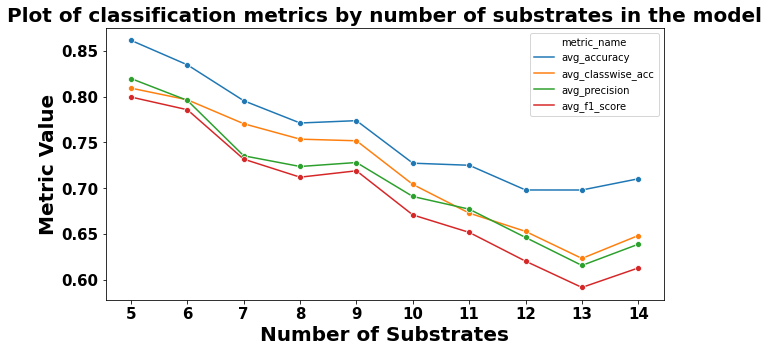

In [26]:
plt.figure(figsize = (10,5))
sns.lineplot(data=melt_best, x="num_substrates", y="metric_value", hue="metric_name",  marker="o")
plt.title("Plot of classification metrics by number of substrates in the model", fontsize = 20 ,weight = "bold")
plt.xlabel("Number of Substrates",  weight = "bold", fontsize = 20)
plt.ylabel("Metric Value", weight = "bold", fontsize = 20)
plt.xticks(range(5,15), weight = "bold", fontsize = 15)
plt.yticks(weight = "bold", fontsize = 15, rotation = 0)
plt.show()

In [27]:
overall_catch.columns

Index(['num_substrates', 'feature_method', 'avg_accuracy', 'avg_classwise_acc',
       'std_err_avg_acc', 'std_err_avg_classwise_acc', 'avg_precision',
       'avg_recall', 'avg_f1_score'],
      dtype='object')

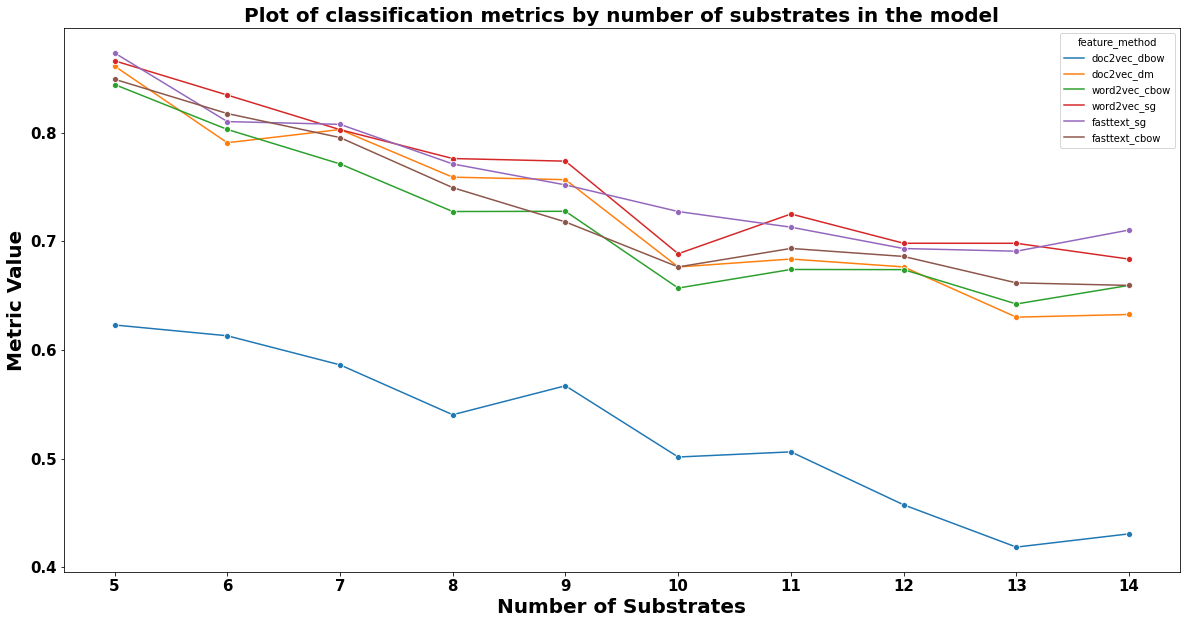

In [29]:
plt.figure(figsize = (20,10))
filter_condn = [ "countvectorizer"]
sns.lineplot(data=overall_catch[~overall_catch["feature_method"].isin(filter_condn)], x="num_substrates", y="avg_accuracy", hue="feature_method",  marker="o")
plt.title("Plot of classification metrics by number of substrates in the model", fontsize = 20 ,weight = "bold")
plt.xlabel("Number of Substrates",  weight = "bold", fontsize = 20)
plt.ylabel("Metric Value", weight = "bold", fontsize = 20)
plt.xticks(range(5,15), weight = "bold", fontsize = 15)
plt.yticks(weight = "bold", fontsize = 15, rotation = 0)
plt.show()